# Landmark vs Traditional System

## Import the required libraries

Simulating Traditional: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


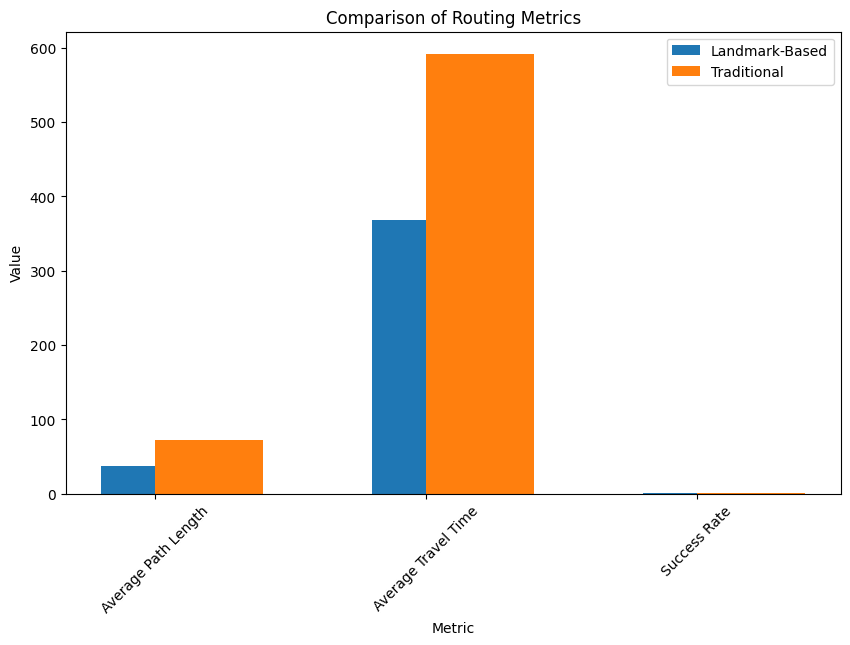

Comparative metrics saved to './data/comparative_metrics.csv'.


In [5]:
import osmnx as ox
import networkx as nx
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import itertools
import matplotlib.pyplot as plt
import h3
from sklearn.cluster import DBSCAN
import numpy as np
from typing import List, Dict


## Landmarks extraction from OSM data

In [ ]:

# Landmark Priority Class
class LandmarkPriority:
    def __init__(self, hex_resolution=7, eps=0.005, min_samples=5, priority_order=None):
        self.hex_resolution = hex_resolution
        self.eps = eps
        self.min_samples = min_samples
        self.priority_order = priority_order if priority_order else [
            "temple", "tourist_spot", "bus_stop", "government_building", "market", "school"
        ]

    def get_hexagons(self, lat: float, lon: float) -> List[str]:
        """
        Generate the H3 hexagons (including neighbors) for a given latitude and longitude.
        """
        h3_index = h3.geo_to_h3(lat, lon, self.hex_resolution)
        return h3.k_ring(h3_index, 1)

    def cluster_landmarks(self, landmarks: List[Dict]) -> np.ndarray:
        """
        Perform DBSCAN clustering on landmarks based on latitude and longitude.
        """
        coords = np.array([(landmark['lat'], landmark['lon']) for landmark in landmarks])
        clustering = DBSCAN(eps=self.eps, min_samples=self.min_samples).fit(coords)
        return clustering.labels_

    def rank_clusters(self, labels: np.ndarray) -> List[tuple]:
        """
        Rank clusters by size, prioritizing larger clusters.
        """
        unique, counts = np.unique(labels, return_counts=True)
        cluster_counts = dict(zip(unique, counts))
        return sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)

    def handle_noise_points(self, landmarks: List[Dict], labels: np.ndarray) -> List[Dict]:
        """
        Handle noise points identified by DBSCAN (those labeled as -1).
        """
        return [landmarks[i] for i in range(len(labels)) if labels[i] == -1]

    def select_priority_landmark(self, landmarks: List[Dict], labels: np.ndarray) -> Dict:
        """
        Select the priority landmark from the largest cluster based on a predefined or custom priority order.
        """
        sorted_clusters = self.rank_clusters(labels)
        top_cluster_label = sorted_clusters[0][0]  # Largest cluster's label

        if top_cluster_label == -1:
            noise_points = self.handle_noise_points(landmarks, labels)
            if noise_points:
                return noise_points[0]  # Return first noise point as fallback

        top_cluster_landmarks = [landmarks[i] for i in range(len(labels)) if labels[i] == top_cluster_label]

        for priority in self.priority_order:
            for landmark in top_cluster_landmarks:
                if landmark['type'] == priority:
                    return landmark

        return top_cluster_landmarks[0]  # Fallback to first landmark in the largest cluster

    def get_priority_landmark_for_hex(self, lat: float, lon: float, landmarks: List[Dict]) -> Dict:
        """
        Identify the priority landmark for a given latitude and longitude by clustering landmarks in hexagons.
        """
        hexagons = self.get_hexagons(lat, lon)
        landmarks_in_hex = [landmark for landmark in landmarks if h3.geo_to_h3(landmark['lat'], landmark['lon'], self.hex_resolution) in hexagons]

        if not landmarks_in_hex:
            return None

        labels = self.cluster_landmarks(landmarks_in_hex)
        return self.select_priority_landmark(landmarks_in_hex, labels)


## Utility functions

In [ ]:

# Function to calculate heuristic for A* algorithm
def heuristic(u, v, G):
    """Custom heuristic function for A* algorithm that calculates great-circle distance."""
    try:
        u_lat, u_lon = G.nodes[u]['y'], G.nodes[u]['x']
        v_lat, v_lon = G.nodes[v]['y'], G.nodes[v]['x']
        return ox.distance.great_circle_vec(u_lat, u_lon, v_lat, v_lon)
    except KeyError as e:
        raise ValueError(f"Missing node attributes for {u} or {v}: {e}")

# Function to process scenarios for landmark-based routing
def process_landmark_scenario(args):
    """Process a single routing scenario for landmark-based systems."""
    building, landmarks, G, landmark_selector = args
    try:
        building_coords = (building['latitude'], building['longitude'])
        priority_landmark = landmark_selector.get_priority_landmark_for_hex(
            building['latitude'], building['longitude'], landmarks
        )

        if not priority_landmark:
            return {'Path Length': None, 'Travel Time': None, 'Status': 'Failed'}

        building_node = ox.distance.nearest_nodes(G, building_coords[1], building_coords[0])
        landmark_node = ox.distance.nearest_nodes(G, priority_landmark['lon'], priority_landmark['lat'])

        if not nx.has_path(G, building_node, landmark_node):
            return {'Path Length': None, 'Travel Time': None, 'Status': 'Failed'}

        path = nx.astar_path(G, building_node, landmark_node, heuristic=lambda u, v: heuristic(u, v, G), weight='travel_time')
        path_length = len(path)
        travel_time = sum(
            G.get_edge_data(path[i], path[i+1])[0].get('travel_time', 0)
            for i in range(len(path)-1)
        )

        return {'Path Length': path_length, 'Travel Time': travel_time, 'Status': 'Success'}
    except Exception as e:
        return {'Path Length': None, 'Travel Time': None, 'Status': 'Failed', 'Error': str(e)}



# Function to process scenarios for traditional routing


In [ ]:
def process_traditional_scenario(args):
    """Process a single routing scenario for traditional systems."""
    building, landmark, G = args
    try:
        building_coords = (building['latitude'], building['longitude'])
        landmark_coords = (landmark['lat'], landmark['lon'])

        building_node = ox.distance.nearest_nodes(G, building_coords[1], building_coords[0])
        landmark_node = ox.distance.nearest_nodes(G, landmark_coords[1], landmark_coords[0])

        if not nx.has_path(G, building_node, landmark_node):
            return {'Path Length': None, 'Travel Time': None, 'Status': 'Failed'}

        path = nx.dijkstra_path(G, building_node, landmark_node, weight='travel_time')
        path_length = len(path)
        travel_time = sum(
            G.get_edge_data(path[i], path[i+1])[0].get('travel_time', 0)
            for i in range(len(path)-1)
        )

        return {'Path Length': path_length, 'Travel Time': travel_time, 'Status': 'Success'}
    except Exception as e:
        return {'Path Length': None, 'Travel Time': None, 'Status': 'Failed', 'Error': str(e)}


## Function to simulate routing for comparison


In [ ]:
def simulate_routing(buildings_df, landmarks_df, G, algorithm='A*', num_scenarios=1000, landmark_selector=None):
    """Simulate routing scenarios and calculate metrics."""
    building_sample = buildings_df.sample(num_scenarios) if num_scenarios else buildings_df
    landmark_sample = landmarks_df.sample(min(num_scenarios, len(landmarks_df))) if num_scenarios else landmarks_df

    if algorithm == 'Landmark':
        args = zip(building_sample.to_dict('records'), itertools.repeat(landmark_sample.to_dict('records')), itertools.repeat(G), itertools.repeat(landmark_selector))
        process_function = process_landmark_scenario
    else:
        args = zip(building_sample.to_dict('records'), itertools.cycle(landmark_sample.to_dict('records')), itertools.repeat(G))
        process_function = process_traditional_scenario

    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_function, args), total=len(building_sample), desc=f"Simulating {algorithm}"))

    return pd.DataFrame(results)


## Simulation Parameters 

In [ ]:

# Load road network and datasets
G = ox.graph_from_place("Kathmandu, Nepal", network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

buildings = pd.read_csv('./data/kathmandu_buildings.csv')
landmarks = pd.read_csv('./data/cleaned_landmarks.csv')

# Initialize LandmarkPriority
landmark_selector = LandmarkPriority()

# Run simulations for both methods
num_scenarios = 100  # Adjust as needed

# Landmark-based routing using priority selection
landmark_results = simulate_routing(buildings, landmarks, G, algorithm='Landmark', num_scenarios=num_scenarios, landmark_selector=landmark_selector)

# Traditional routing using street-based navigation
traditional_results = simulate_routing(buildings, landmarks, G, algorithm='Traditional', num_scenarios=num_scenarios)

# Compare metrics
comparison_df = pd.DataFrame({
    'Metric': ['Average Path Length', 'Average Travel Time', 'Success Rate'],
    'Landmark-Based': [
        landmark_results['Path Length'].mean(),
        landmark_results['Travel Time'].mean(),
        (landmark_results['Status'] == 'Success').mean()
    ],
    'Traditional': [
        traditional_results['Path Length'].mean(),
        traditional_results['Travel Time'].mean(),
        (traditional_results['Status'] == 'Success').mean()
    ]
})


## Visualization


In [ ]:

plt.figure(figsize=(10, 6))
x = comparison_df['Metric']
plt.bar(x, comparison_df['Landmark-Based'], width=0.4, label='Landmark-Based', align='center')
plt.bar(x, comparison_df['Traditional'], width=0.4, label='Traditional', align='edge')
plt.title("Comparison of Routing Metrics")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Save the comparative metrics
comparison_df.to_csv('./data/comparative_metrics.csv', index=False)
print("Comparative metrics saved to './data/comparative_metrics.csv'.")


In [7]:
comparison_df

,Metric,Landmark-Based,Traditional
0,Average Path Length,37.480,71.840
1,Average Travel Time,368.961,592.219
2,Success Rate,1.000,1.000


In [ ]:
Metric	Landmark-Based	Traditional
0	Average Path Length	37.480	71.840
1	Average Travel Time	368.961	592.219
2	Success Rate	1.000	1.000